In [84]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pylab
from Bio import SeqIO
from Bio import Phylo
from ete3 import Tree, NodeStyle, TreeStyle, faces, ClusterTree, AttrFace, \
    ProfileFace, TextFace, CircleFace, RectFace
import pandas as pd
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib.backends.backend_pdf import PdfPages
from PyQt4 import QtCore
from PyQt4.QtGui import QGraphicsRectItem, QGraphicsSimpleTextItem, \
    QGraphicsEllipseItem, QColor, QPen, QBrush
import colorsys
import random
import math
%matplotlib inline

In [2]:
def checkSlash(directory):
    if directory[-1] != '/':
        directory = directory + '/'
    return directory

def importMapping(inFile):
    mapping = {}
    with open(inFile, 'r') as f:
        for line in f:
            if '#' == line[0]:
                continue
            line = line.strip().split('\t')
            mapping[line[0]] = line[2]
    return mapping

def editNexus(inFile, outFile):
    outF = open(outFile, 'w')
    with open(inFile, 'r') as f:
        for line in f:
            if 'color=' in line:
                line = line.split('[')[0] + '\n'
            elif line == 'end\n':
                line = 'end;'
            elif ';end;' in line:
                line = line.replace(';end;', ';\nend;')
            elif 'figtree' in line:
                break
            outF.write(line)
    outF.close()

In [3]:
#Specify user paths
subgroup = 'subB'
subgroup_long = 'subgroupB'
oldPath = '/Users/sarahspencer/Dropbox/2017_05_Pseudo_Spence/' + subgroup_long + '/tree_counting/'
refPath = '/Users/sarahspencer/Dropbox/Reference_Genomes/Pseudomonas_' + subgroup + '/'
snpFile = '/Users/sarahspencer/Dropbox/2017_05_Pseudo_Spence/' + subgroup_long + '/' + 'snptable.csv'
newPath = 'subgroupB/'
if not os.path.exists(newPath):
    os.makedirs(newPath)
treeFile = '1_2_177683.tree'

In [4]:
#Reformat trees for ete toolkit
outTree = newPath + treeFile
editNexus(oldPath + treeFile, outTree)
outNewick = outTree.replace('.tree', '.nhx')
Phylo.convert(outTree, 'nexus', outNewick, 'newick')
mapping = importMapping('map_v2.txt')

{'FW216': '#4c72b0', 'MPR': '#4e7ca3', 'FW602': '#4f8695', 'NA': '#519187', 'FW507': '#539b79', 'FW300': '#55a66b', 'GW101': '#669a65', 'FW305': '#7a8a61', 'GP01': '#90785c', 'MPBC4': '#a66758', 'GW247': '#bb5554', 'MPBD4': '#bc525d', 'GW123': '#af5970', 'FW104': '#a26083', 'FW306': '#966794', 'GW458': '#896ea7', 'DP16D': '#8778ad', 'FW510': '#9685a1', 'FW301': '#a49395', 'FW215': '#b3a189', 'MPBD7': '#c0ae7e', 'GW456': '#c8b977', 'GW460': '#b4b889', 'GW704': '#9fb79a', 'GW531': '#8bb6ac', 'FW126': '#76b6bd', 'FW303': '#64b5cd'}


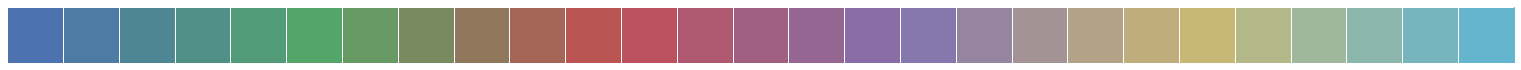

In [5]:
#CREATING COLOR MAP FOR SOURCE WELLS
#Map well to color
metaFile = open('map_v2.txt', 'r')
colorDict = {}
for line in metaFile:
    if '#' not in line:
        line = line.strip().split('\t')
        wellID = line[2].split('-')[0]
        if wellID not in colorDict:
            colorDict[wellID] = ''
metaFile.close()
numColors = len(colorDict)
cmap = sns.color_palette('deep')
paletteList = []
for i,p in enumerate(cmap.as_hex()):
    paletteList.append(p)
cmap2 = sns.blend_palette(paletteList, numColors)
sns.set_palette(cmap2, n_colors=numColors)
sns.palplot(cmap2)
for i,p in enumerate(cmap2.as_hex()):
    wellID = list(colorDict.keys())[i]
    colorDict[wellID] = p
print(colorDict)

In [72]:
#Prepare to plot contig positions
#Assumes a 'NODE_##_length_##_' file name structure
#Assumes nodes start counting from 1
contigs = {}
for f in os.listdir(refPath):
    if '.gb' in f:
        node = f.split('_')[1]
        length = f.split('_')[3]
        contigs[node] = length

def getTotalPos(contig, pos):
    total = 0
    for i in range(len(contigs)):
        c = str(i+1)
        if c == contig:
            total += int(pos)
            return total
        else:
            total += int(contigs[c])

print(getTotalPos('10', '182981'))
print(getTotalPos('36', '2080'))

3986499
7127391


In [132]:
def addWellNodes(tree):
    for leaf in tree:
        leaf.name = mapping[leaf.name.split('--')[0]] + '--' + leaf.name.split('--')[1]
        wellName = leaf.name.split('-')[0]
        nstyle = NodeStyle()
        thisColor = colorDict[wellName]
        nstyle["fgcolor"] = thisColor
        nstyle["size"] = 15
        leaf.set_style(nstyle)

def getAnnotation(contig, pos):
    snpTable = open(snpFile, 'r')
    for line in snpTable:
        line = line.strip().split(',')
        if (line[0] == contig) and (line[1] == pos):
            snpTable.close()
            return line[3].strip(), line[4].strip(), line[2].strip()
    snpTable.close()

def addLeafSNPs(coreTree, snpNewick, ts, i):
    #Open and edit snpTree
    snpTree = Tree(outNewick)
    addWellNodes(snpTree)
    ####
    #Identify gene changes at this location
    contig = snpNewick.split('_')[1]
    pos = snpNewick.split('_')[2].replace('.nhx', '')
    gene, protein, ns = getAnnotation(contig, pos)
    ####
    #Get input SNPs
    leafDict = {}
    for leaf in snpTree:
        leafName = leaf.name.split('--')[0]
        if '--*T' in leaf.name:
            leafDict[leafName] = 'yellow'
        elif '--*A' in leaf.name:
            leafDict[leafName] = 'blue'
        elif '--*G' in leaf.name:
            leafDict[leafName] = 'green'
        elif '--*C' in leaf.name:
            leafDict[leafName] = 'red' #red
        else:
            leafDict[leafName] = 'grey'
    ####
    #Add face column to tree
    for leaf in coreTree:
        leafName = leaf.name.split('--')[0]
        snpColor = leafDict[leafName]
        c = RectFace(15, 15, snpColor, snpColor)
        c.opacity = 0.4
        leaf.add_face(c, i, position='aligned')
    ####
    #Set TreeStyle so that gene name appears above
    t = faces.TextFace(gene + ' ' + protein, fsize=15)
    t.rotation = 270
    if ns == 'N':
        t.bold = True
        ts.aligned_header.add_face(t, i)
    else:
        ts.aligned_header.add_face(t, i)
    ####
    #Set TreeStyle so that gene position appears below
    length = getTotalPos(contig, pos) * 0.00004
    f = faces.RectFace(5, length, 'grey', 'grey')
    f.vt_align = 2
    f.hz_align = 1
    ts.aligned_foot.add_face(f, i)
    return coreTree, ts

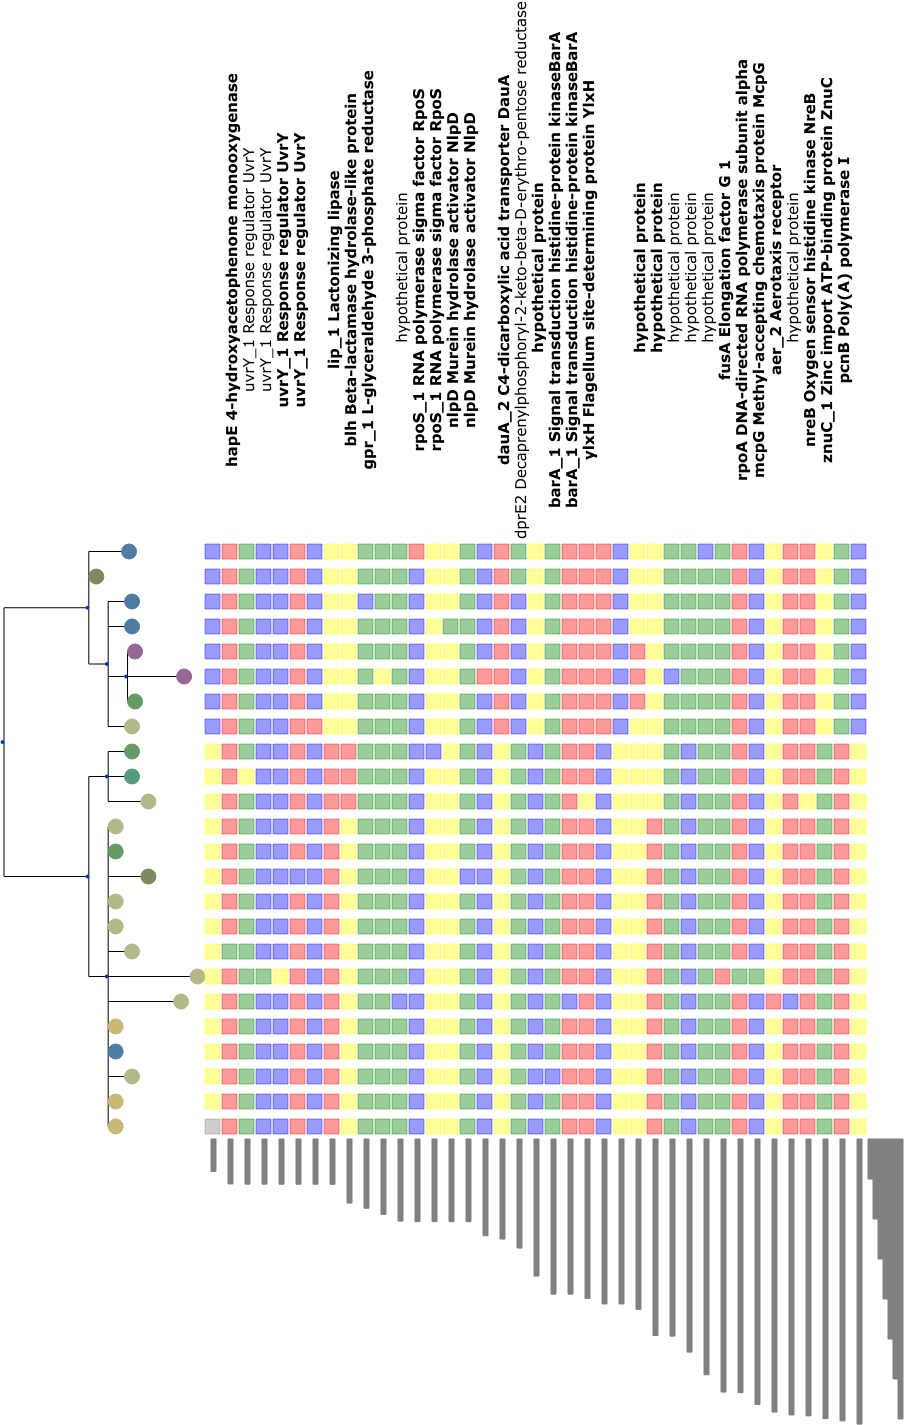

In [133]:
tree = Tree(outNewick)
addWellNodes(tree)
ts = TreeStyle()
ts.branch_vertical_margin = 10
ts.allow_face_overlap = False
ts.show_scale = False
ts.show_leaf_name = False
i = 0

#Reroot at midpoint
outgroup = tree.get_midpoint_outgroup()
tree.set_outgroup(outgroup)

with open(snpFile, 'r') as snps:
    for line in snps:
        if 'Contig' not in line:
            contig = line.strip().split(',')[0]
            pos = line.strip().split(',')[1]
            treeName = '1_' + contig + '_' + pos + '.tree'
            outTree = newPath + treeName
            editNexus(oldPath + treeName, outTree)
            outNewick = outTree.replace('.tree', '.nhx')
            Phylo.convert(outTree, 'nexus', outNewick, 'newick')
            tree, ts = addLeafSNPs(tree, outNewick, ts, i)
            i += 1

#Add scale
for j in range(7):
    a = j + 1
    f = faces.RectFace(5, a * 1000000 * 0.00004, 'grey', 'grey')
    f.vt_align = 2
    ts.aligned_foot.add_face(f, i + j)

tree.render("trial.svg", units='in', h=22, w=16, dpi=300, tree_style=ts)
tree.render("%%inline", tree_style=ts)

In [ ]:
#add scale
#fix gene label line-up

In [ ]:
#collate geography
#plot geography!!

In [ ]:
#make tree w/in tree with snp trees!!